In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import zipfile

# Data Collection

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d deadskull7/fer2013

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
  0% 0.00/96.6M [00:00<?, ?B/s]
100% 96.6M/96.6M [00:00<00:00, 1.40GB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/fer2013.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv("/content/fer2013.csv")

In [ ]:
def process_pixels(pixel_string):
    return np.array(pixel_string.split(), dtype='float32').reshape(48, 48) / 255.0

df['pixels'] = df['pixels'].apply(process_pixels)

In [ ]:
print("Unique emotion labels:", sorted(df['emotion'].unique()))
print("Label value counts:")
print(df['emotion'].value_counts().sort_index())

Unique emotion labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Label value counts:
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: count, dtype: int64


In [ ]:
if df['emotion'].min() < 0 or df['emotion'].max() > 6:
    print("Warning: Found labels outside expected range 0-6")
    # Filter out invalid labels
    df = df[(df['emotion'] >= 0) & (df['emotion'] <= 6)]
    print(f"Filtered dataset size: {len(df)}")

In [ ]:
train_data = df[df['Usage'] == 'Training'].copy()
val_data   = df[df['Usage'] == 'PublicTest'].copy()
test_data  = df[df['Usage'] == 'PrivateTest'].copy()
print("Training samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))

Training samples: 28709
Validation samples: 3589
Test samples: 3589


# Data Augmentation

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        pixels = self.dataframe.iloc[idx]['pixels']

        # Convert to PIL Image and ensure it's grayscale (fix deprecation warning)
        image = Image.fromarray(np.uint8(pixels * 255)).convert('L')

        label = int(self.dataframe.iloc[idx]['emotion'])

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
train_dataset = FER2013Dataset(train_data, transform=train_transform)
val_dataset   = FER2013Dataset(val_data, transform=test_transform)
test_dataset  = FER2013Dataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Model

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=7):  # FER2013 has 7 emotion classes (0-6)
        super(MyCNN, self).__init__()

        self.features = nn.Sequential(
            # First block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Changed from 3 to 1 input channel
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),

            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),

            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),

            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
        )

        # Calculate the size after convolutions: 48 -> 24 -> 12 -> 6 -> 3
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# SetUp for training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For debugging CUDA errors, you can set this environment variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = MyCNN(num_classes=7).to(device)
learning_rate = 0.001  # Reduced learning rate
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Using device: cuda


# Training Loop

In [ ]:
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for batch_idx, (batch_features, batch_labels) in enumerate(train_loader):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


Epoch 1/50, Batch 0/449, Loss: 2.0156
Epoch 1/50, Batch 100/449, Loss: 1.8163
Epoch 1/50, Batch 200/449, Loss: 1.7425
Epoch 1/50, Batch 300/449, Loss: 1.6361
Epoch 1/50, Batch 400/449, Loss: 1.7345
Epoch 2/50, Batch 0/449, Loss: 1.4627
Epoch 2/50, Batch 100/449, Loss: 1.6064
Epoch 2/50, Batch 200/449, Loss: 1.4287
Epoch 2/50, Batch 300/449, Loss: 1.2516
Epoch 2/50, Batch 400/449, Loss: 1.4062
Epoch 3/50, Batch 0/449, Loss: 1.2014
Epoch 3/50, Batch 100/449, Loss: 1.4956
Epoch 3/50, Batch 200/449, Loss: 1.4783
Epoch 3/50, Batch 300/449, Loss: 1.4137
Epoch 3/50, Batch 400/449, Loss: 1.4396
Epoch 4/50, Batch 0/449, Loss: 1.3721
Epoch 4/50, Batch 100/449, Loss: 1.3837
Epoch 4/50, Batch 200/449, Loss: 1.2582
Epoch 4/50, Batch 300/449, Loss: 1.2357
Epoch 4/50, Batch 400/449, Loss: 1.1272
Epoch 5/50, Batch 0/449, Loss: 1.2945
Epoch 5/50, Batch 100/449, Loss: 1.5266
Epoch 5/50, Batch 200/449, Loss: 1.3462
Epoch 5/50, Batch 300/449, Loss: 1.1124
Epoch 5/50, Batch 400/449, Loss: 1.2431
Epoch 6/50

# Validation Loop

In [ ]:
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    avg_val_loss = val_loss / len(val_loader)

    scheduler.step()

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}')
    print(f'  Val Accuracy: {val_accuracy:.2f}%')
    print('-' * 50)

Epoch 50/50:
  Train Loss: 0.8998
  Val Loss: 1.0032
  Val Accuracy: 63.33%
--------------------------------------------------


# Test Loop

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {test_accuracy:.2f}%')

# --- Save the model ---
torch.save(model.state_dict(), 'fer2013_cnn_model.pth')
print("Model saved successfully!")

Final Test Accuracy: 64.59%
Model saved successfully!


🎭 EMOTION RECOGNITION TEST
📁 Please upload an image file (JPG, PNG, etc.)
   Choose an image with clear faces for best results!


Saving WhatsApp Image 2025-08-12 at 17.16.00_73b70bcc.jpg to WhatsApp Image 2025-08-12 at 17.16.00_73b70bcc.jpg
📷 Processing: WhatsApp Image 2025-08-12 at 17.16.00_73b70bcc.jpg
🔧 Using device: cuda
✅ Model loaded successfully on cuda
👥 Found 9 face(s)

🎯 Analyzing Face 1:
--------------------
🏆 Top prediction: Happy (1.000)
📊 All predictions:
   1. Happy      1.000 ███████████████████
   2. Neutral    0.000 
   3. Angry      0.000 
   4. Surprise   0.000 
   5. Sad        0.000 

🎯 Analyzing Face 2:
--------------------
🏆 Top prediction: Neutral (0.462)
📊 All predictions:
   1. Neutral    0.462 █████████
   2. Sad        0.206 ████
   3. Angry      0.166 ███
   4. Happy      0.084 █
   5. Fear       0.067 █

🎯 Analyzing Face 3:
--------------------
🏆 Top prediction: Neutral (0.629)
📊 All predictions:
   1. Neutral    0.629 ████████████
   2. Sad        0.173 ███
   3. Happy      0.091 █
   4. Angry      0.082 █
   5. Fear       0.023 

🎯 Analyzing Face 4:
--------------------
🏆 Top pre

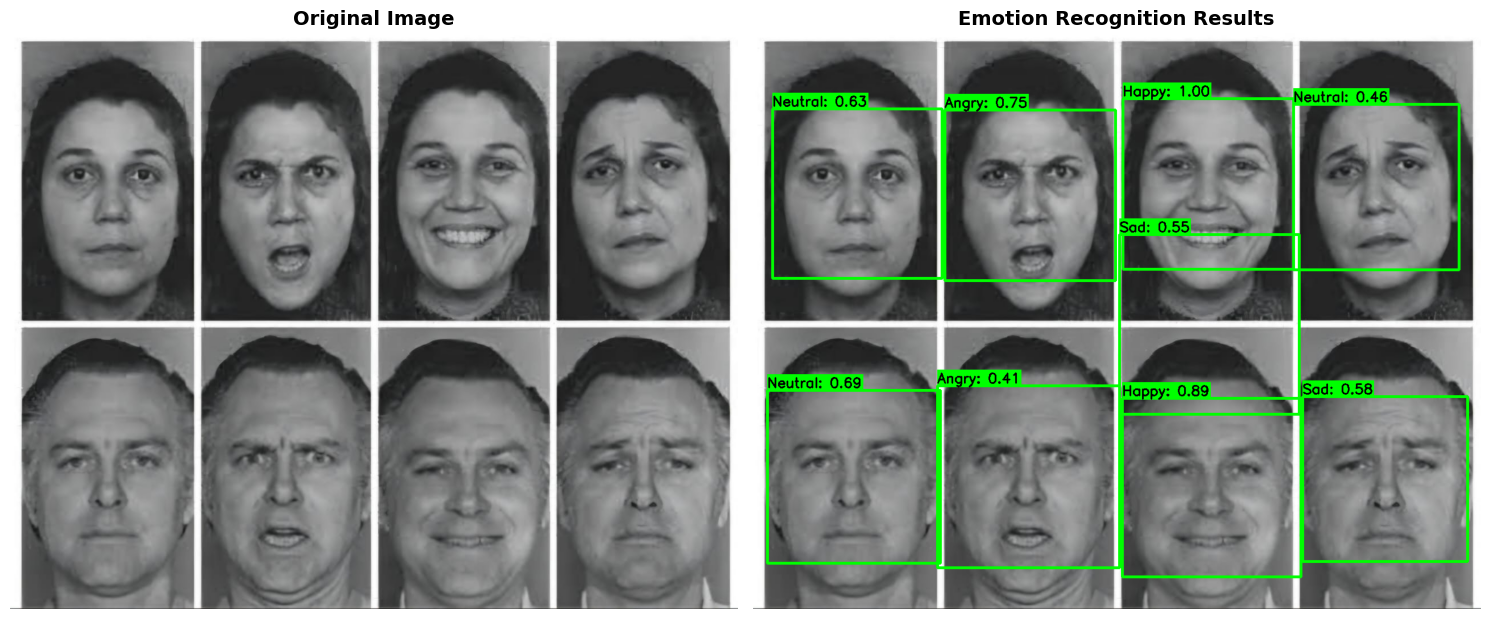


🎉 ANALYSIS COMPLETE!
📈 Processed 9 face(s) successfully

👥 Individual Face Analysis:


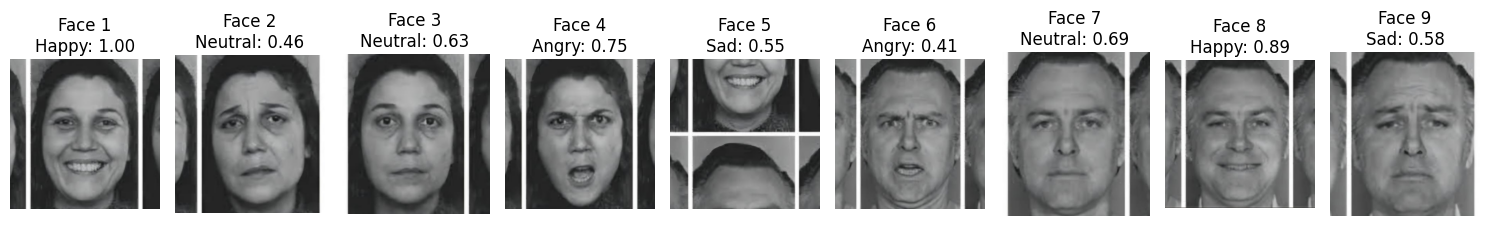

In [ ]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Your CNN architecture (must match training)
class MyCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(MyCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def load_model(model_path, device):
    """Load the trained emotion recognition model"""
    try:
        model = MyCNN(num_classes=7).to(device)
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"✅ Model loaded successfully on {device}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def create_transforms():
    """Create preprocessing transforms matching training"""
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return transform

def predict_emotion_from_face(model, face_image, transform, device, emotion_labels):
    """Predict emotion from a detected face"""
    try:
        # Convert to PIL and grayscale
        if len(face_image.shape) == 3:
            face_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(face_rgb).convert('L')
        else:
            pil_image = Image.fromarray(face_image).convert('L')

        # Apply transforms
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.softmax(output, dim=1)

            # Get all predictions sorted by confidence
            probs, indices = torch.sort(probabilities, dim=1, descending=True)
            predictions = []
            for i in range(len(emotion_labels)):
                emotion = emotion_labels[indices[0][i].item()]
                confidence = probs[0][i].item()
                predictions.append((emotion, confidence))

            return predictions

    except Exception as e:
        print(f"❌ Error in prediction: {e}")
        return [("Error", 0.0)]

def test_emotion_recognition():
    """Main function to upload image and test emotion recognition"""

    print("🎭 EMOTION RECOGNITION TEST")
    print("=" * 40)

    # Upload file
    print("📁 Please upload an image file (JPG, PNG, etc.)")
    print("   Choose an image with clear faces for best results!")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded")
        return

    # Get uploaded filename
    filename = list(uploaded.keys())[0]
    print(f"📷 Processing: {filename}")

    # Setup device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🔧 Using device: {device}")

    # Load model
    model = load_model("fer2013_cnn_model.pth", device)
    if model is None:
        print("❌ Failed to load model")
        return

    # Setup
    emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    transform = create_transforms()

    # Load and process image
    try:
        image = cv2.imread(filename)
        if image is None:
            print("❌ Could not load image")
            return

        # Convert for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Load face detector
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Detect faces with multiple scales for better detection
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        print(f"👥 Found {len(faces)} face(s)")

        if len(faces) == 0:
            print("⚠️  No faces detected. Try uploading a clearer image with visible faces.")
            # Still show the original image
            plt.figure(figsize=(10, 6))
            plt.imshow(image_rgb)
            plt.title("Original Image (No Faces Detected)")
            plt.axis('off')
            plt.show()
            return

        # Create result image
        result_image = image_rgb.copy()

        # Process each face
        all_predictions = []
        for i, (x, y, w, h) in enumerate(faces):
            print(f"\n🎯 Analyzing Face {i+1}:")
            print("-" * 20)

            # Extract face with padding
            padding = int(0.2 * max(w, h))
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(image.shape[1], x + w + padding)
            y2 = min(image.shape[0], y + h + padding)

            face_roi = image[y1:y2, x1:x2]

            # Predict emotions
            predictions = predict_emotion_from_face(model, face_roi, transform, device, emotion_labels)
            all_predictions.append(predictions)

            if predictions and predictions[0][0] != "Error":
                # Get top prediction
                top_emotion, top_confidence = predictions[0]

                # Draw rectangle around face
                color = (0, 255, 0) if top_confidence > 0.3 else (255, 165, 0)  # Green if confident, orange if not
                cv2.rectangle(result_image, (x, y), (x+w, y+h), color, 3)

                # Add prediction text
                text = f"{top_emotion}: {top_confidence:.2f}"
                font_scale = 0.8
                thickness = 2

                # Get text size for background
                (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

                # Draw background rectangle for text
                cv2.rectangle(result_image, (x, y-text_height-10), (x+text_width, y), color, -1)

                # Draw text
                cv2.putText(result_image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)

                # Print detailed results
                print(f"🏆 Top prediction: {top_emotion} ({top_confidence:.3f})")
                print("📊 All predictions:")
                for j, (emotion, confidence) in enumerate(predictions[:5]):  # Show top 5
                    bar = "█" * int(confidence * 20)  # Visual bar
                    print(f"   {j+1}. {emotion:10} {confidence:.3f} {bar}")

        # Display results
        plt.figure(figsize=(15, 10))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(image_rgb)
        plt.title("Original Image", fontsize=14, fontweight='bold')
        plt.axis('off')

        # Result image
        plt.subplot(1, 2, 2)
        plt.imshow(result_image)
        plt.title("Emotion Recognition Results", fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Summary
        print(f"\n🎉 ANALYSIS COMPLETE!")
        print(f"📈 Processed {len(faces)} face(s) successfully")

        # Show individual face crops if multiple faces
        if len(faces) > 1:
            print(f"\n👥 Individual Face Analysis:")
            plt.figure(figsize=(15, 5))
            for i, (x, y, w, h) in enumerate(faces):
                # Extract and show face crop
                padding = int(0.2 * max(w, h))
                x1 = max(0, x - padding)
                y1 = max(0, y - padding)
                x2 = min(image.shape[1], x + w + padding)
                y2 = min(image.shape[0], y + h + padding)

                face_crop = image_rgb[y1:y2, x1:x2]

                plt.subplot(1, len(faces), i+1)
                plt.imshow(face_crop)

                if all_predictions[i] and all_predictions[i][0][0] != "Error":
                    emotion, confidence = all_predictions[i][0]
                    plt.title(f"Face {i+1}\n{emotion}: {confidence:.2f}", fontsize=12)
                else:
                    plt.title(f"Face {i+1}\nError", fontsize=12)
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"❌ Error processing image: {e}")
        import traceback
        traceback.print_exc()

# Run the test
if __name__ == "__main__":
    test_emotion_recognition()